## Data Cleaning & Preprocessing in SageMaker Studio (20 minutes)
### Launch SageMaker Studio

Open SageMaker in AWS Console

Click "Studio" → "Open Studio"

Create new notebook (Python 3 Data Science kernel)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
#from sagemaker import Session
#import sagemaker

# Initialize SageMaker session
#sagemaker_session = Session()
#bucket = sagemaker_session.default_bucket()
#role = sagemaker.get_execution_role()

# Load data from S3
#data_path = f's3://{bucket}/data/raw/customer_churn.csv'
data_path = "./data/customer_churn.csv"
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nColumn names:")
print(df.columns.tolist())

print("\nTarget variable distribution:")
print(df['Churn'].value_counts())

print("\nBasic statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Data types breakdown
print("\nNumerical columns:")
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(numerical_cols)

print("\nCategorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

Dataset shape: (440833, 12)

First 5 rows:
   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  
3          

## EDA

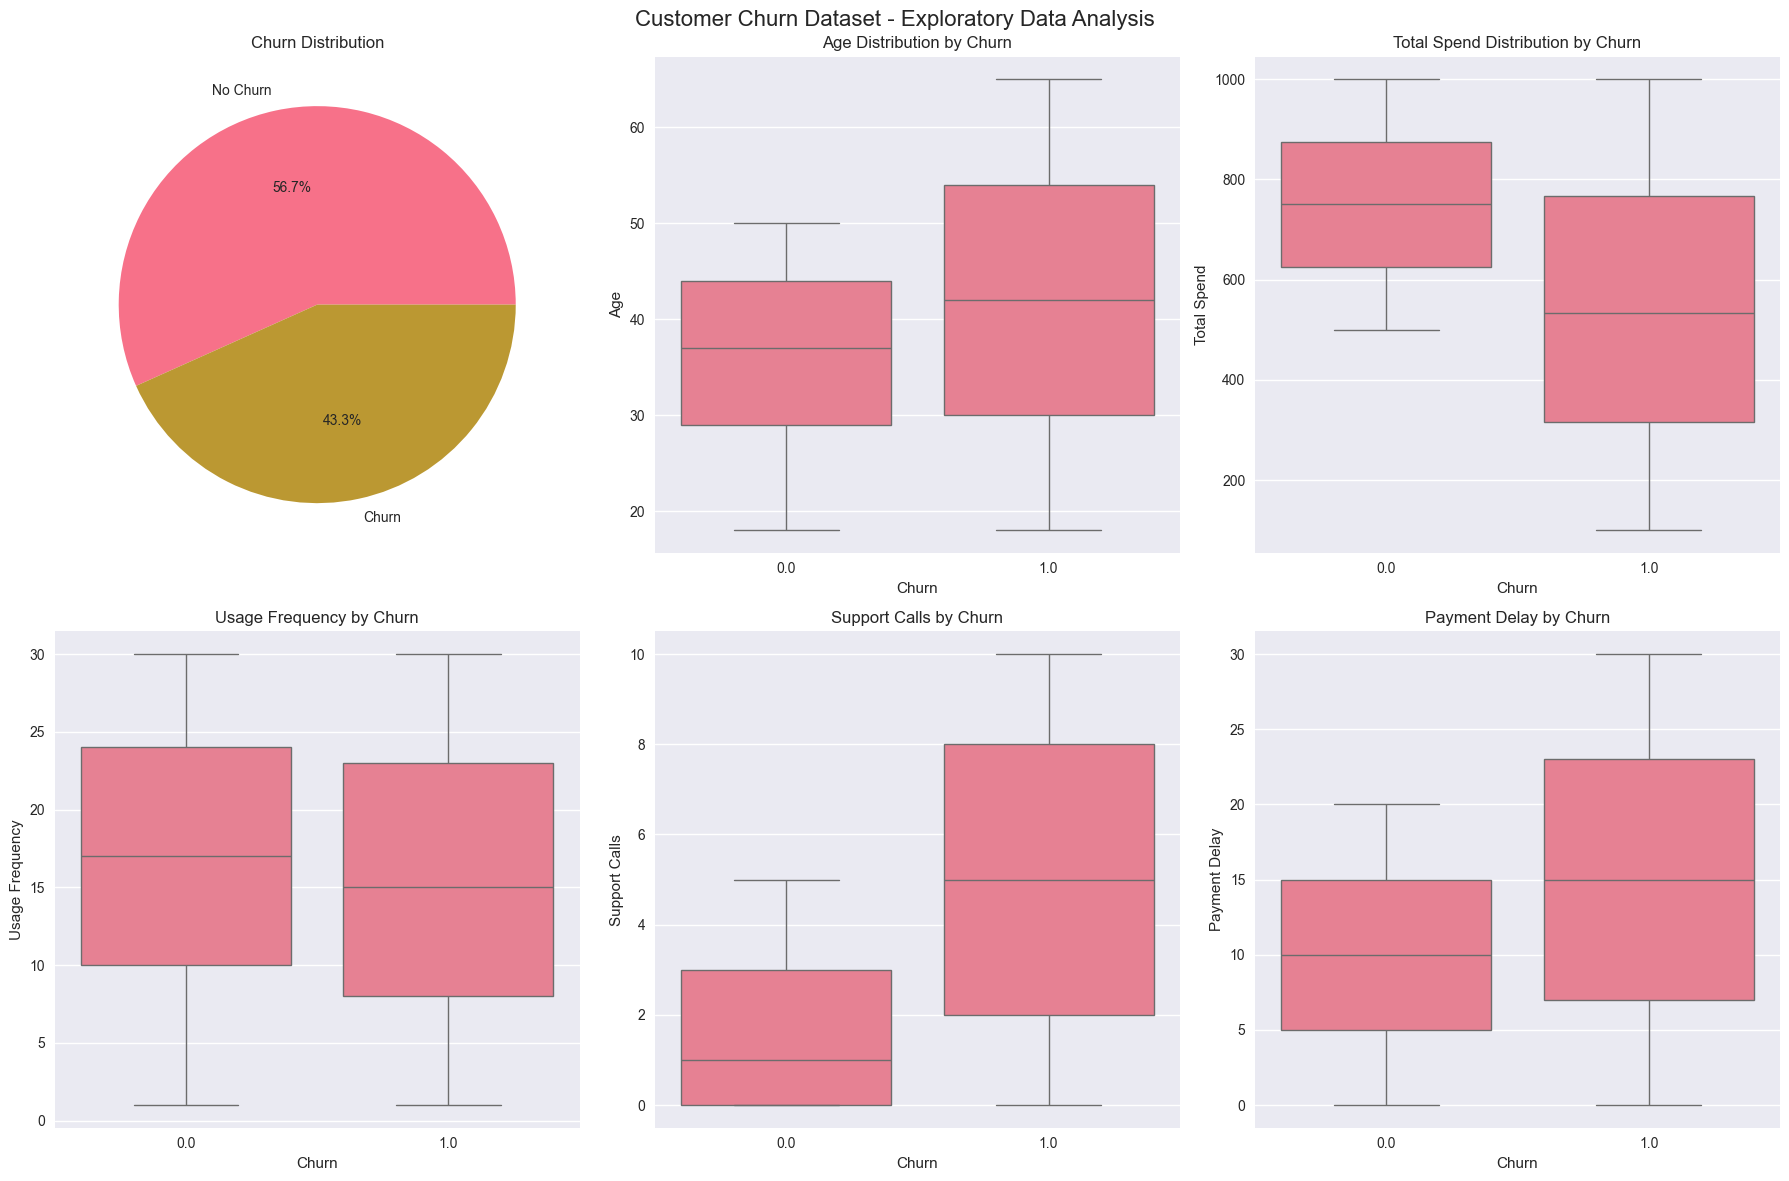

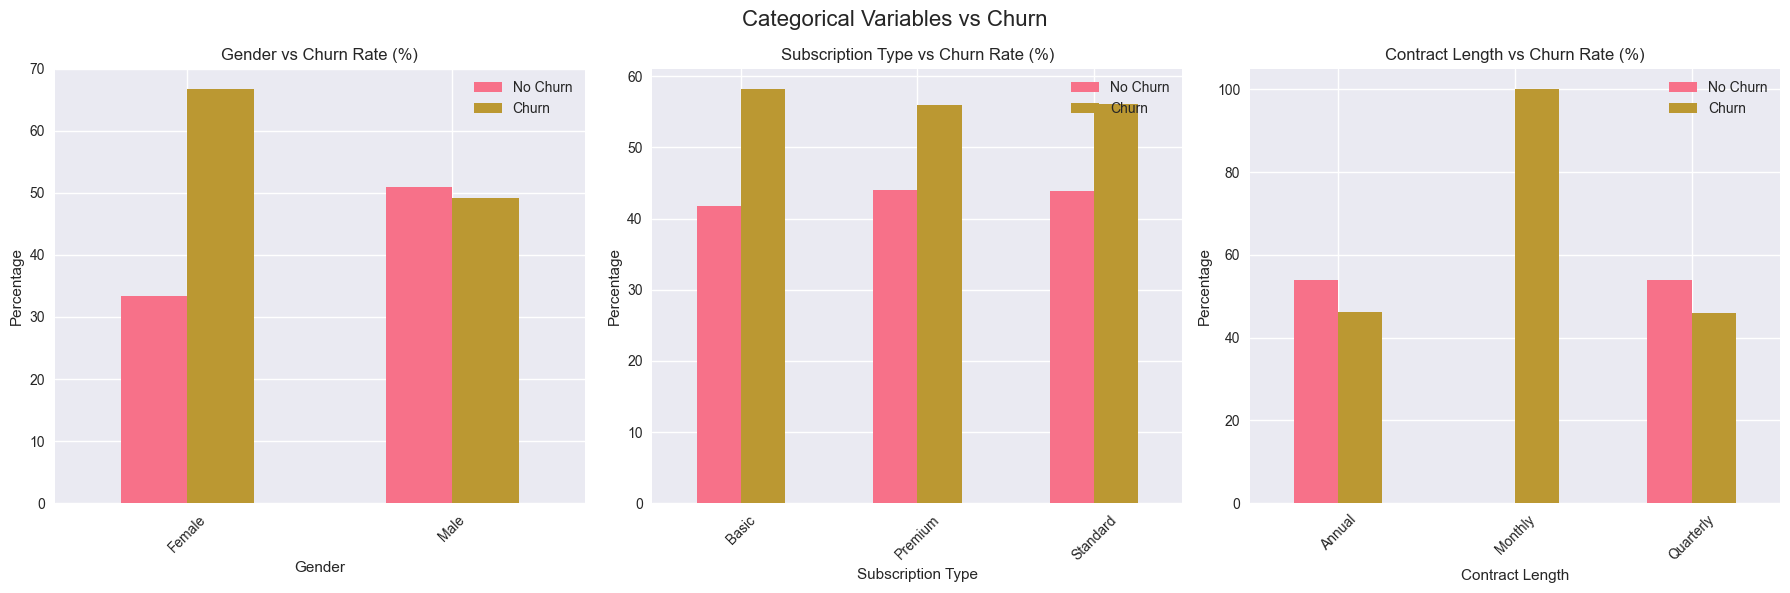

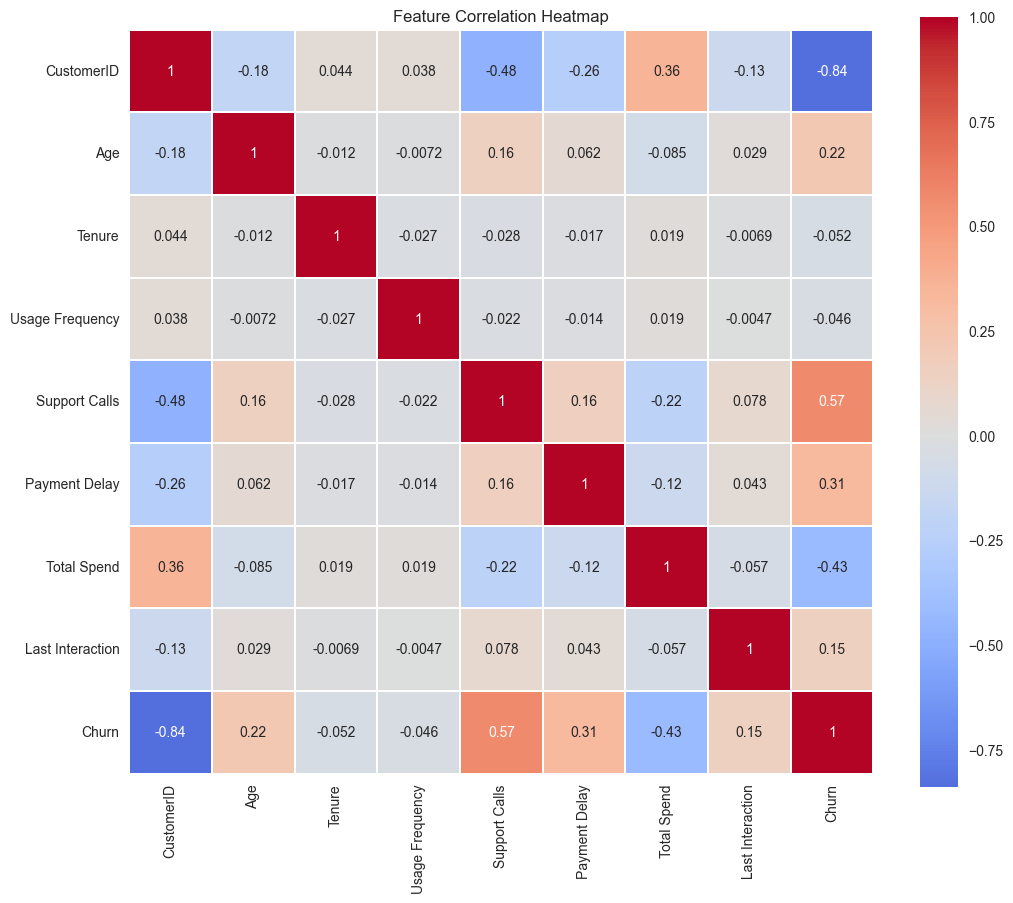

In [2]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create subplots for EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Customer Churn Dataset - Exploratory Data Analysis', fontsize=16)

# 1. Churn distribution
axes[0, 0].pie(df['Churn'].value_counts(), labels=['No Churn', 'Churn'], autopct='%1.1f%%')
axes[0, 0].set_title('Churn Distribution')

# 2. Age distribution by churn
sns.boxplot(data=df, x='Churn', y='Age', ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Churn')

# 3. Total Spend distribution by churn
sns.boxplot(data=df, x='Churn', y='Total Spend', ax=axes[0, 2])
axes[0, 2].set_title('Total Spend Distribution by Churn')

# 4. Usage Frequency distribution by churn
sns.boxplot(data=df, x='Churn', y='Usage Frequency', ax=axes[1, 0])
axes[1, 0].set_title('Usage Frequency by Churn')

# 5. Support Calls distribution by churn
sns.boxplot(data=df, x='Churn', y='Support Calls', ax=axes[1, 1])
axes[1, 1].set_title('Support Calls by Churn')

# 6. Payment Delay distribution by churn
sns.boxplot(data=df, x='Churn', y='Payment Delay', ax=axes[1, 2])
axes[1, 2].set_title('Payment Delay by Churn')

plt.tight_layout()
plt.show()

# Categorical variables analysis
categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Categorical Variables vs Churn', fontsize=16)

for i, col in enumerate(categorical_cols):
    churn_crosstab = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    churn_crosstab.plot(kind='bar', ax=axes[i], rot=45)
    axes[i].set_title(f'{col} vs Churn Rate (%)')
    axes[i].set_ylabel('Percentage')
    axes[i].legend(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.1)
plt.title('Feature Correlation Heatmap')
plt.show()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

## Data Preprocessing Pipeline

In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

def preprocess_data(df):
    """Comprehensive data preprocessing pipeline for customer churn dataset"""
    df.dropna(inplace=True)
    # Make a copy to avoid modifying original
    processed_df = df.copy()
    
    # Remove CustomerID as it's not useful for prediction
    if 'CustomerID' in processed_df.columns:
        processed_df = processed_df.drop('CustomerID', axis=1)
    
    # Check for missing values (though your data shows no nulls)
    print("Missing values check:")
    print(processed_df.isnull().sum())
    
    # Define column types based on your dataset
    numerical_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 
                     'Payment Delay', 'Total Spend', 'Last Interaction']
    categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']
    target_col = 'Churn'
    
    # Separate features and target
    X = processed_df.drop(target_col, axis=1)
    y = processed_df[target_col]
    
    # Create preprocessing pipelines
    # For numerical features: StandardScaler
    numerical_transformer = StandardScaler()
    
    # For categorical features: OneHotEncoder
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    # Fit and transform the features
    X_processed = preprocessor.fit_transform(X)
    
    # Get feature names after preprocessing
    numerical_feature_names = numerical_cols
    categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    all_feature_names = list(numerical_feature_names) + list(categorical_feature_names)
    
    # Create DataFrame with processed features
    X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
    
    print(f"Original features: {X.shape[1]}")
    print(f"Processed features: {X_processed_df.shape[1]}")
    print(f"Feature names: {all_feature_names}")
    
    return X_processed_df, y, preprocessor, all_feature_names

# Apply preprocessing
X_processed, y, preprocessor, feature_names = preprocess_data(df)

print("Preprocessing completed!")
print(f"Features shape: {X_processed.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Display first few rows of processed data
print("\nFirst 5 rows of processed features:")
print(X_processed.head())

Missing values check:
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64
Original features: 10
Processed features: 12
Feature names: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Gender_Male', 'Subscription Type_Premium', 'Subscription Type_Standard', 'Contract Length_Monthly', 'Contract Length_Quarterly']
Preprocessing completed!
Features shape: (440832, 12)
Target shape: (440832,)
Target distribution:
Churn
1.0    249999
0.0    190833
Name: count, dtype: int64

First 5 rows of processed features:
        Age    Tenure  Usage Frequency  Support Calls  Payment Delay  \
0 -0.753326  0.448760        -0.210511       0.454549       0.609620   
1  2.059646  1.028278        -1.724562       2.083100      -0.601319   
2  1

In [17]:
# Combine processed features and target
final_dataset = pd.concat([X_processed, y.reset_index(drop=True)], axis=1)

print("Final dataset shape:", final_dataset.shape)
print("Final dataset columns:", final_dataset.columns.tolist())

# Save processed data to S3
#processed_path = f's3://{bucket}/data/processed/customer_churn_processed.csv'
processed_path = "./data/customer_churn_processed.csv"
final_dataset.to_csv(processed_path, index=False)

print(f"Processed data saved to: {processed_path}")

# Also save locally for quick access
local_processed_path = 'customer_churn_processed.csv'
final_dataset.to_csv(local_processed_path, index=False)
print(f"Processed data also saved locally to: {local_processed_path}")

# Save preprocessing object for later use
import joblib
joblib.dump(preprocessor, 'preprocessor.joblib')
print("Preprocessor saved as 'preprocessor.joblib'")

# Display final dataset info
print("\nFinal dataset summary:")
print(f"Total samples: {len(final_dataset)}")
print(f"Total features: {len(feature_names)}")
print(f"Churn rate: {(final_dataset['Churn'].sum() / len(final_dataset) * 100):.2f}%")

Final dataset shape: (440832, 13)
Final dataset columns: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Gender_Male', 'Subscription Type_Premium', 'Subscription Type_Standard', 'Contract Length_Monthly', 'Contract Length_Quarterly', 'Churn']
Processed data saved to: ./data/customer_churn_processed.csv
Processed data also saved locally to: customer_churn_processed.csv
Preprocessor saved as 'preprocessor.joblib'

Final dataset summary:
Total samples: 440832
Total features: 12
Churn rate: 56.71%


In [18]:
y.isna().sum()

0

## Part 4: Model Training with Cloud Compute (20 minutes)
#### Method 1: In-Notebook Training (Quick)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set churn rate: {(y_train.sum() / len(y_train) * 100):.2f}%")
print(f"Test set churn rate: {(y_test.sum() / len(y_test) * 100):.2f}%")

# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

results = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_roc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Train final model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    test_accuracy = model.score(X_test, y_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std(),
        'cv_roc_auc_mean': cv_roc_scores.mean(),
        'cv_roc_auc_std': cv_roc_scores.std(),
        'test_accuracy': test_accuracy,
        'test_roc_auc': test_roc_auc,
        'model': model
    }
    
    predictions[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  CV ROC-AUC: {cv_roc_scores.mean():.4f} (+/- {cv_roc_scores.std() * 2:.4f})")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Test ROC-AUC: {test_roc_auc:.4f}")

# Select best model based on ROC-AUC
best_model_name = max(results.keys(), key=lambda x: results[x]['test_roc_auc'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} (ROC-AUC: {results[best_model_name]['test_roc_auc']:.4f})")

# Detailed classification report for best model
print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, predictions[best_model_name]['y_pred']))

# Feature importance for Random Forest
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Feature Importances (Random Forest):")
    print(feature_importance.head(10))

Training set shape: (352665, 12)
Test set shape: (88167, 12)
Training set churn rate: 56.71%
Test set churn rate: 56.71%

Training Random Forest...
  CV Accuracy: 0.9994 (+/- 0.0002)
  CV ROC-AUC: 1.0000 (+/- 0.0000)
  Test Accuracy: 0.9996
  Test ROC-AUC: 1.0000

Training Logistic Regression...
  CV Accuracy: 0.8959 (+/- 0.0029)
  CV ROC-AUC: 0.9597 (+/- 0.0016)
  Test Accuracy: 0.8934
  Test ROC-AUC: 0.9590

Training XGBoost...
  CV Accuracy: 0.9999 (+/- 0.0001)
  CV ROC-AUC: 1.0000 (+/- 0.0000)
  Test Accuracy: 0.9999
  Test ROC-AUC: 1.0000

Best model: XGBoost (ROC-AUC: 1.0000)

Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38167
         1.0       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167


Top 10 Feature Importances (Random Forest):
   

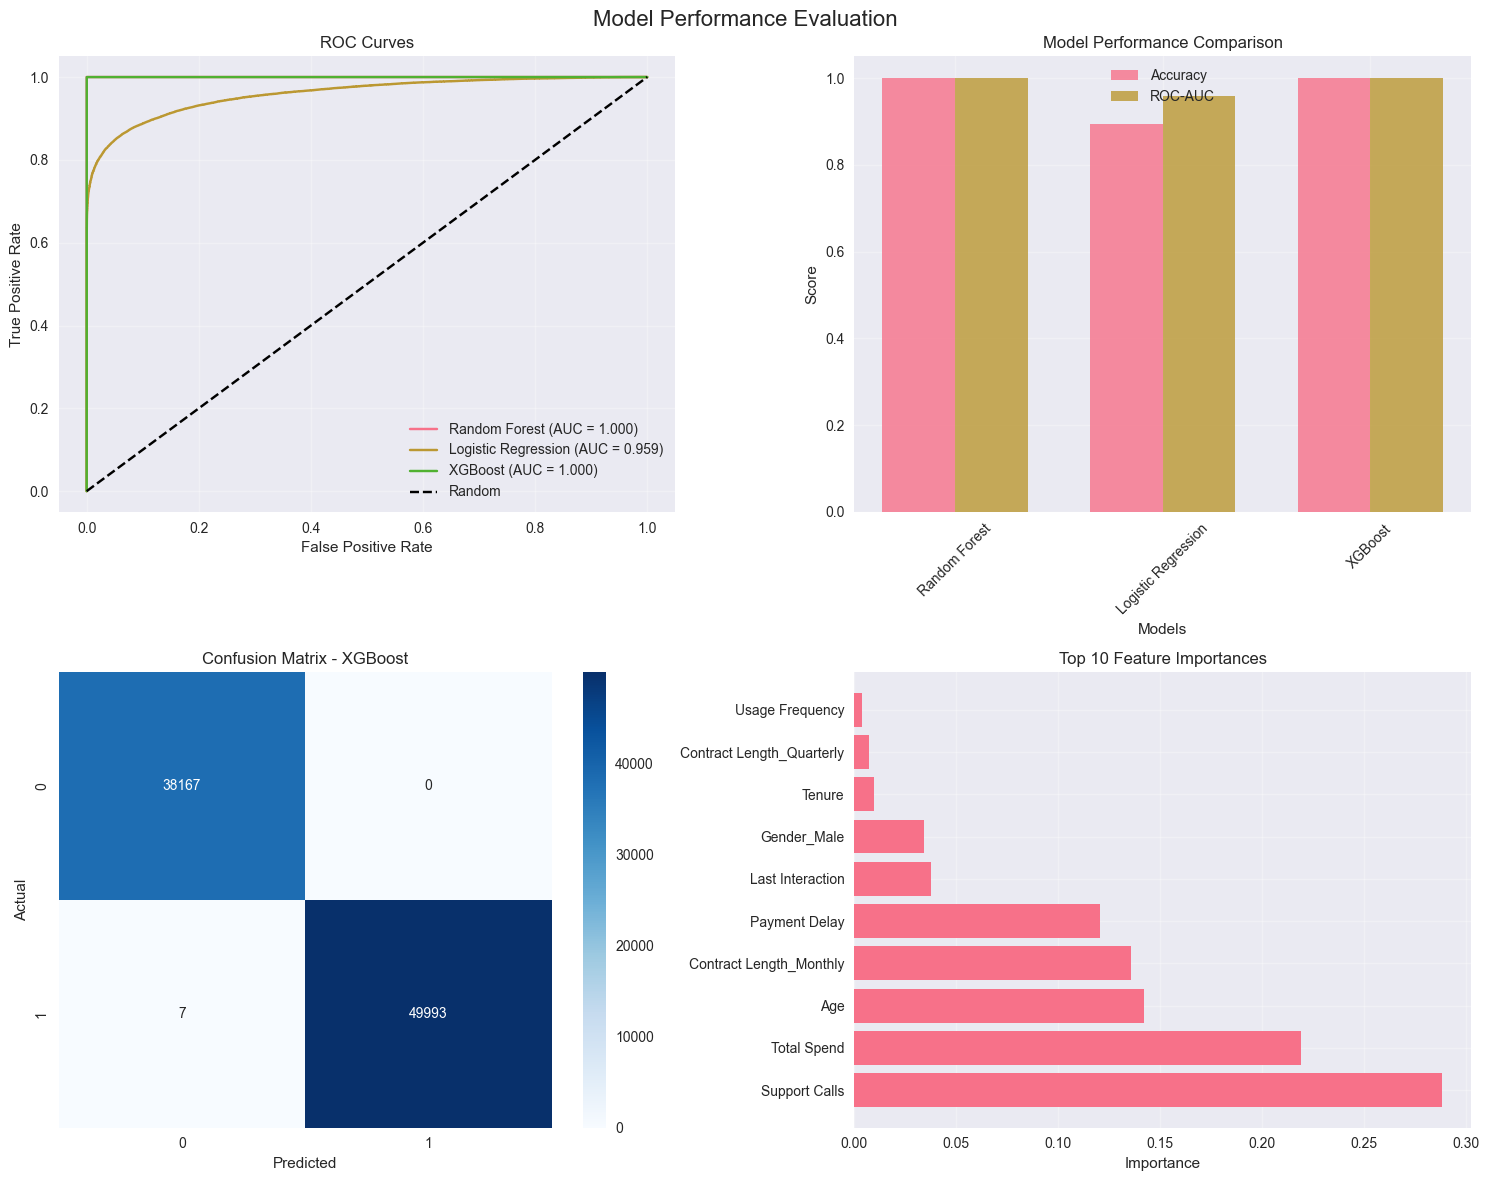


Best model saved as: best_model_xgboost.joblib

MODEL TRAINING SUMMARY
Dataset: 440832 samples, 12 features after preprocessing
Churn rate: 56.71%
Best model: XGBoost
Best model test accuracy: 0.9999
Best model test ROC-AUC: 1.0000
Model saved to: best_model_xgboost.joblib
Preprocessor saved to: preprocessor.joblib


In [20]:
# Model Evaluation Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Evaluation', fontsize=16)

# 1. ROC Curves
ax1 = axes[0, 0]
for name in models.keys():
    y_pred_proba = predictions[name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = results[name]['test_roc_auc']
    ax1.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Model Comparison - Test Scores
ax2 = axes[0, 1]
model_names = list(results.keys())
accuracy_scores = [results[name]['test_accuracy'] for name in model_names]
roc_auc_scores = [results[name]['test_roc_auc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

ax2.bar(x - width/2, accuracy_scores, width, label='Accuracy', alpha=0.8)
ax2.bar(x + width/2, roc_auc_scores, width, label='ROC-AUC', alpha=0.8)

ax2.set_xlabel('Models')
ax2.set_ylabel('Score')
ax2.set_title('Model Performance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix for Best Model
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, predictions[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_title(f'Confusion Matrix - {best_model_name}')

# 4. Feature Importance (if Random Forest is available)
ax4 = axes[1, 1]
if 'Random Forest' in results:
    top_features = feature_importance.head(10)
    ax4.barh(range(len(top_features)), top_features['importance'])
    ax4.set_yticks(range(len(top_features)))
    ax4.set_yticklabels(top_features['feature'])
    ax4.set_xlabel('Importance')
    ax4.set_title('Top 10 Feature Importances')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Feature importance\nnot available for\nselected models', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Feature Importance')

plt.tight_layout()
plt.show()

# Save the best model
import joblib
best_model_path = f'best_model_{best_model_name.lower().replace(" ", "_")}.joblib'
joblib.dump(best_model, best_model_path)
print(f"\nBest model saved as: {best_model_path}")

# Model summary
print(f"\n{'='*50}")
print("MODEL TRAINING SUMMARY")
print(f"{'='*50}")
print(f"Dataset: {len(df)} samples, {len(feature_names)} features after preprocessing")
print(f"Churn rate: {(y.sum() / len(y) * 100):.2f}%")
print(f"Best model: {best_model_name}")
print(f"Best model test accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print(f"Best model test ROC-AUC: {results[best_model_name]['test_roc_auc']:.4f}")
print(f"Model saved to: {best_model_path}")
print(f"Preprocessor saved to: preprocessor.joblib")